In [104]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import snowballstemmer
import string


# Getting the Data From Eksisozluk

I used https://github.com/coluck/eksisozluk-api for scraping the data from
Eksisozluk. It's based on node.js, and it returns data in a json format.

In [2]:
def entries_to_text(entry_dataframe: pd.DataFrame) -> str:
    """A function to merge all of the entries in a page given by the Eksisozluk
    API. Also handles the removal of HTML tags found in the raw results from
    the API."""
    final_text = ''
    for entry in entry_dataframe['body']:
        soup = BeautifulSoup(entry)
        final_text = ' '.join([final_text, soup.get_text()])
    return final_text

In [3]:
def scan_pages_to_str(start_page: int, end_page: int, header_link: str) -> str:
    """A function that uses Eksisozluk API to process all of the entries in the 
    given page range to a string."""
    text_out = ''
    for i in range(start_page, end_page):
        req = requests.get(f"{header_link}?p={i}")
        entries = pd.DataFrame.from_dict(req.json()["entries"])
        text_out = ' '.join([text_out, entries_to_text(entries)])
    return text_out       

In [4]:
def scan_pages_to_df(start_page: int, end_page: int, header_link: str) -> pd.DataFrame:
    """A function that uses Eksisozluk API to process all of the entries in the 
    given page range to a Pandas Data Frame. Also handles the removal of HTML
    tags found in the raw results from the API."""
    df_out = pd.DataFrame()
    soup = BeautifulSoup()
    for i in range(start_page, end_page):
        req = requests.get(f"{header_link}?p={i}")
        entries = pd.DataFrame(req.json()["entries"])
        df_out = pd.concat([entries, df_out])
    df_out = df_out.reset_index(drop=True)
    df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]
    return df_out

In [21]:
def sum_sentiment(df: pd.DataFrame) -> int:
    sentiment = 0
    for i in range(len(df)):
        if df["sentiment_data"][i]["label"] == "positive":
            sentiment += df["sentiment_data"][i]["score"]
        else:
            sentiment -= df["sentiment_data"][i]["score"]
    return sentiment

# Fine-Tuned BERTurk Based Model

## Kılıçdaroğlu

Getting some entries about the main opposition candidate:

In [ ]:
#Page 4247 corresponds to entries written on May 1
# Page 4404 ends the night before the election day
kilicdar_text = scan_pages_to_df(4247, 4404, 'http://localhost:3000/api/baslik/kemal-kilicdaroglu--1267550')

/var/folders/t3/37z1vnv119jd4057sptnmv900000gn/T/ipykernel_10191/452042521.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]


In [7]:
sent_model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sent_tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sentiment_pipeline = pipeline("sentiment-analysis", tokenizer=sent_tokenizer, model=sent_model)

Filtering out entries that produce more than 512 tokens.

In [8]:
sent_tokenizer(kilicdar_text["cleaned_body"][0])

{'input_ids': [2, 23307, 2916, 9200, 2977, 1031, 15847, 23307, 18, 3137, 3348, 10865, 2336, 2009, 12588, 2368, 18, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
kilicdar_clean = kilicdar_text.copy()

In [10]:
for i in range(len(kilicdar_clean["cleaned_body"])):
    if len(sent_tokenizer(kilicdar_clean["cleaned_body"][i])["input_ids"]) > 512:
        kilicdar_clean.drop(i, inplace=True)
kilicdar_clean = kilicdar_clean.reset_index(drop=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (3088 > 512). Running this sequence through the model will result in indexing errors


In [11]:
sentiment_pipeline(list(kilicdar_clean["cleaned_body"])[:2])

[{'label': 'positive', 'score': 0.9536780118942261},
 {'label': 'positive', 'score': 0.8818874955177307}]

In [12]:
kilicdar_clean_sentiments_small = kilicdar_clean.iloc[:5].copy()
kilicdar_clean_sentiments_small["sentiment_data"] = [sentiment_pipeline(list(kilicdar_clean_sentiments_small["cleaned_body"])[i])[0] for i in range(len(kilicdar_clean_sentiments_small))]
kilicdar_clean_sentiments_small

,id,body,author,author_id,fav_count,created_at,updated_at,cleaned_body,sentiment_data
0,152320352,dedem cumhurbaşkanı olacaksın dedem.<br>millet...,lordwilmore,1656166,0,13.05.2023 22:09,None,dedem cumhurbaşkanı olacaksın dedem.millet sen...,"{'label': 'positive', 'score': 0.9536780118942..."
1,152320492,allahına kurban olduğum inşallah iyisindir ken...,khradein,1938203,0,13.05.2023 22:12,None,allahına kurban olduğum inşallah iyisindir ken...,"{'label': 'positive', 'score': 0.8818874955177..."
2,152320539,"şafak doğan güneş.<br>edit, zifiri karanlığa u...",tekmeyiyemisadam,2143156,1,13.05.2023 22:13,18.05.2023 22:35,"şafak doğan güneş.edit, zifiri karanlığa uyandık.","{'label': 'negative', 'score': 0.843242883682251}"
3,152320750,sahnede olduğu süre içinde en baştan beri kend...,masterful tactician,57691,1,13.05.2023 22:17,None,sahnede olduğu süre içinde en baştan beri kend...,"{'label': 'positive', 'score': 0.9862686991691..."
4,152320919,bu adam inanılmaz bir şey yapıyor.<br><br>20 y...,umth,631887,9,13.05.2023 22:20,None,bu adam inanılmaz bir şey yapıyor.20 yıldır sü...,"{'label': 'positive', 'score': 0.9924404621124..."


In [13]:
kilicdar_clean_sentiments_small["sentiment_data"][0]

{'label': 'positive', 'score': 0.9536780118942261}

In [14]:
kilicdar_clean_sentiments = kilicdar_clean.copy()
kilicdar_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(kilicdar_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(kilicdar_clean_sentiments))]

In [24]:
sum_sentiment(kilicdar_clean_sentiments) / len(kilicdar_clean_sentiments)

-0.03723159125593842

## Tayyip

In [16]:
#Page 6917 corresponds to entries written on May 1
# Page 7026 ends the night before the election day
tayyip_text = scan_pages_to_df(6917, 7026, 'http://localhost:3000/api/baslik/recep-tayyip-erdogan--95281')

/var/folders/t3/37z1vnv119jd4057sptnmv900000gn/T/ipykernel_10191/452042521.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df_out["cleaned_body"] = [BeautifulSoup(entry).get_text() for entry in df_out["body"]]


In [17]:
tayyip_clean = tayyip_text.copy()

In [18]:
for i in range(len(tayyip_clean["cleaned_body"])):
    if len(sent_tokenizer(tayyip_clean["cleaned_body"][i])["input_ids"]) > 512:
        tayyip_clean.drop(i, inplace=True)
tayyip_clean = tayyip_clean.reset_index(drop=True)

In [19]:
tayyip_clean_sentiments = tayyip_clean.copy()
tayyip_clean_sentiments["sentiment_data"] = [sentiment_pipeline(list(tayyip_clean_sentiments["cleaned_body"])[i])[0] for i in range(len(tayyip_clean_sentiments))]

In [26]:
sum_sentiment(tayyip_clean_sentiments) / len(tayyip_clean_sentiments)

-0.2999883693328408

# Word Clouds

## Kılıçdaroğlu

In [90]:
kilicdar_str = " ".join(kilicdar_clean["cleaned_body"])

In [91]:
kilicdar_str_tokenized = word_tokenize(kilicdar_str, language="turkish")

In [92]:
stop_words = stopwords.words("turkish")
kilicdar_str_tokenized_without_stopwords = [token for token in kilicdar_str_tokenized if not token in stop_words]

In [105]:
stemmer = snowballstemmer.stemmer("turkish")
kilicdar_stemmed = stemmer.stemWords(kilicdar_str_tokenized_without_stopwords)
kilicdar_stemmed_punctless = [word for word in kilicdar_stemmed if word not in string.punctuation]

Prepare the word cloud.

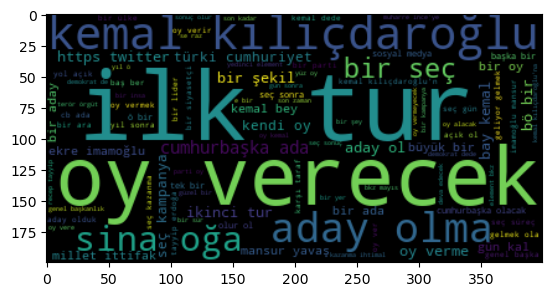

In [120]:
kilicdar_cloud_str = " ".join(kilicdar_stemmed_punctless)
cloud = WordCloud(collocation_threshold=3).generate(kilicdar_cloud_str)
plt.imshow(cloud, interpolation="bilinear")